# WORSKSHOP : Building an AI Classifier: Identifying Cats, Dogs & Pandas with PyTorch

**Name :** CHANDRAPRIYADHARSHINI

**Reg.No :** 212223240019

In [1]:
#import libraries
import torch
import torch.nn as nn #for building neural networks
import torch.nn.functional as func #for training neural networks
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models #for image datasets, transformations and pretrained models
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
import numpy as np 
import pandas as pd #for data handling and analysis
import matplotlib.pyplot as plt #for plotting graphs
import os #for file path management

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate image randomly +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # Flip half of the images horizantally 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
#same for test image but without random augmentations
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
#Load cat/dog images using imagefolder
root = r"C:\Users\priya\DEEP\workshop(cat,dog)\Data\cat-dog-pandas"

In [5]:
train_data = datasets.ImageFolder(os.path.join(root, "train"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(root, "test"), transform=test_transform)

In [6]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True) #shuffle for rsndomizing training samples
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

In [7]:
class_names = train_data.classes

In [8]:
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog', 'panda']
Training images available: 2100
Testing images available:  1


In [10]:
#Loads VG19 model pretrained on imagenet-helps transfer learning
VGG19model = models.vgg19(pretrained=True)

In [11]:
for param in VGG19model.parameters():
    param.requires_grad = False

In [12]:
torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024), #converts VGG's output feauture (25088)->hidden 1024 neurons
    nn.ReLU(), #apply ReLU activation function
    nn.Dropout(0.4), #and prevent overfitting
    nn.Linear(1024, 3), #final layer outputs 3 classess (cat/dog/pandas)
    nn.LogSoftmax(dim=1) #for stable log probabilities
)

In [13]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
3072
3


In [14]:
criterion = nn.CrossEntropyLoss() #measures prediction error.
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001) #Adam optimizer updates classifier parameters.

In [15]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []
#Loop throudh epochs and batches for training.
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Model predicts-> compute loss between predicted and actual labels.
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        #Claculate how many images in the batch were correctly classified
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backpropagation: compute gradients and update weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

#Diplay total training time
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1  batch: 21 loss: 0.0000 accuracy: 70.24%
epoch: 1  batch: 41 loss: 0.0000 accuracy: 82.32%
epoch: 1  batch: 61 loss: 9.5797 accuracy: 85.66%
epoch: 1  batch: 81 loss: 0.0000 accuracy: 87.35%
epoch: 2  batch: 21 loss: 0.0000 accuracy: 90.48%
epoch: 2  batch: 41 loss: 0.0000 accuracy: 93.90%
epoch: 2  batch: 61 loss: 0.0000 accuracy: 94.26%
epoch: 2  batch: 81 loss: 0.0000 accuracy: 94.44%
epoch: 3  batch: 21 loss: 4.7964 accuracy: 89.29%
epoch: 3  batch: 41 loss: 0.2960 accuracy: 90.85%
epoch: 3  batch: 61 loss: 0.0000 accuracy: 91.39%
epoch: 3  batch: 81 loss: 12.6569 accuracy: 92.28%

Duration: 470 seconds


In [16]:
#display total test accuracy
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(1), tensor(1), tensor(1)]
Test accuracy: 100.000%


In [17]:
# Inverse normalize the images (to view the image properly)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

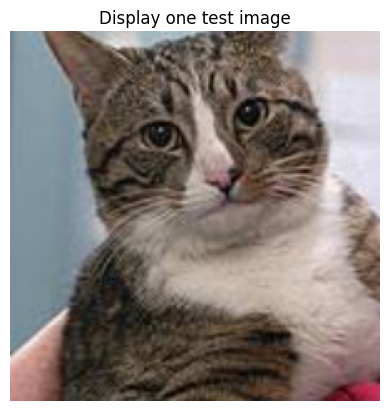

In [18]:
image_index = 0
im = inv_normalize(test_data[image_index][0])

#display one test image
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.title("Display one test image")
plt.axis('off')
plt.show()

In [19]:
len(test_data)

1

In [20]:
#Predcits whether the displayed image
VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

'cat'

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

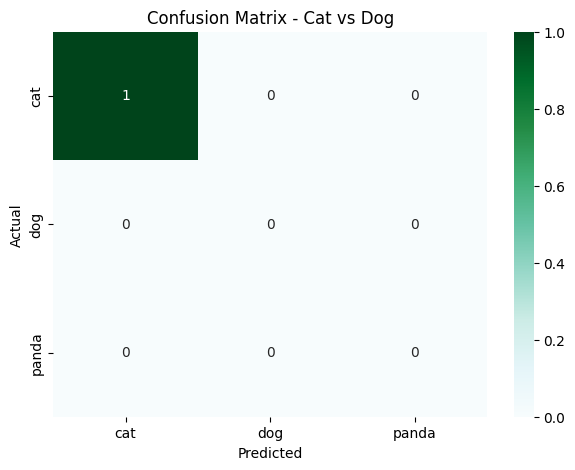

In [24]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val, 1)[1]

        # Collect results from all batches
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Build confusion matrix
arr = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

# Convert to DataFrame with class names
df_cm = pd.DataFrame(arr, index=class_names, columns=class_names)

# Plot heatmap
plt.figure(figsize=(7,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Cat vs Dog")
plt.show()